In [16]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

file_path = '/Users/gali/Desktop/dsmp-2024-group15/Python files/LSTM/SARIMAX_asks.csv'
ask = pd.read_csv(file_path)
print(ask)
ask['adjusted_time_hours'] = pd.to_timedelta(ask['adjusted_time_hours'], unit='h')
start_date = pd.to_datetime('2025-01-01')
ask['datetime'] = start_date + ask['adjusted_time_hours']
ask.set_index('datetime', inplace=True)
ask = ask.drop('adjusted_time_hours',axis = 1)
ask = ask.drop('Type',axis = 1)
print(ask)

     Type  adjusted_time_hours       Price
0     ask                  0.0  259.058784
1     ask                  1.0  257.922733
2     ask                  2.0  266.827586
3     ask                  3.0  280.176471
4     ask                  4.0  283.926437
...   ...                  ...         ...
1058  ask               1058.0  115.226240
1059  ask               1059.0  115.324496
1060  ask               1060.0  113.814666
1061  ask               1061.0  114.353052
1062  ask               1062.0  114.180948

[1063 rows x 3 columns]
                          Price
datetime                       
2025-01-01 00:00:00  259.058784
2025-01-01 01:00:00  257.922733
2025-01-01 02:00:00  266.827586
2025-01-01 03:00:00  280.176471
2025-01-01 04:00:00  283.926437
...                         ...
2025-02-14 02:00:00  115.226240
2025-02-14 03:00:00  115.324496
2025-02-14 04:00:00  113.814666
2025-02-14 05:00:00  114.353052
2025-02-14 06:00:00  114.180948

[1063 rows x 1 columns]


In [50]:
import pmdarima as pm

model = pm.auto_arima(ask,
                      seasonal=True,  
                      m=17,           
                      d=None,          
                      D=None,         
                      max_p=5, max_q=5, 
                      max_P=2, max_Q=2, 
                      trace=True,     
                      error_action='ignore',  
                      suppress_warnings=True,  
                      stepwise=True)  

# 输出模型概要
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[17] intercept   : AIC=6314.520, Time=2.95 sec
 ARIMA(0,1,0)(0,0,0)[17] intercept   : AIC=6341.860, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[17] intercept   : AIC=6314.486, Time=0.49 sec
 ARIMA(0,1,1)(0,0,1)[17] intercept   : AIC=6317.360, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[17]             : AIC=6340.724, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[17] intercept   : AIC=6319.074, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[17] intercept   : AIC=6316.471, Time=2.57 sec
 ARIMA(1,1,0)(1,0,1)[17] intercept   : AIC=6316.477, Time=0.85 sec
 ARIMA(1,1,0)(0,0,1)[17] intercept   : AIC=6314.504, Time=0.39 sec
 ARIMA(1,1,0)(2,0,1)[17] intercept   : AIC=6312.332, Time=5.18 sec
 ARIMA(1,1,0)(2,0,2)[17] intercept   : AIC=inf, Time=10.07 sec
 ARIMA(1,1,0)(1,0,2)[17] intercept   : AIC=inf, Time=5.99 sec
 ARIMA(0,1,0)(2,0,1)[17] intercept   : AIC=6328.072, Time=3.40 sec
 ARIMA(2,1,0)(2,0,1)[17] intercept   : AIC=6309.548, Time=5.66 sec
 ARIMA(2,1,0)(1,0,1)[17] int

/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.10750D+00    |proj g|=  5.42396D-02

At iterate    5    f=  2.95501D+00    |proj g|=  4.00443D-02

At iterate   10    f=  2.94841D+00    |proj g|=  2.08292D-02

At iterate   15    f=  2.94668D+00    |proj g|=  1.20762D-03

At iterate   20    f=  2.94664D+00    |proj g|=  3.42600D-03

At iterate   25    f=  2.94568D+00    |proj g|=  7.79706D-03

At iterate   30    f=  2.94555D+00    |proj g|=  8.89579D-04

At iterate   35    f=  2.94555D+00    |proj g|=  1.79179D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

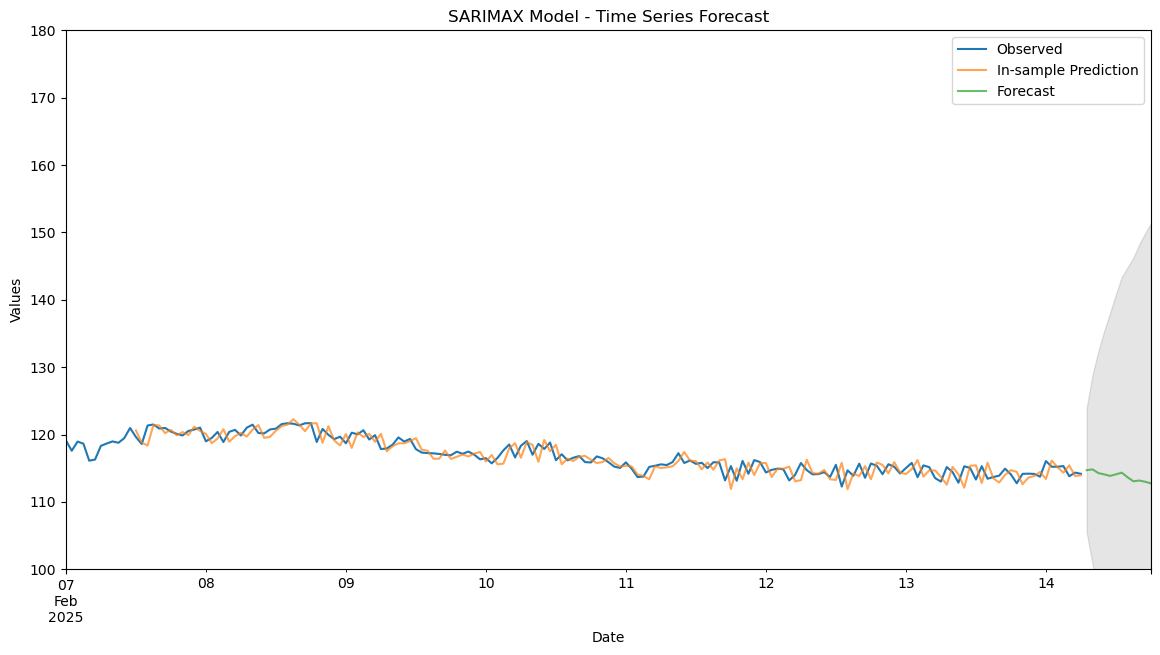

In [17]:
model = SARIMAX(ask.Price, order=(2, 1, 1), seasonal_order=(2, 1, 1, 17))
results = model.fit()

# Make in-sample prediction and forecast
prediction = results.get_prediction(start=900, dynamic=False)
predicted_mean = prediction.predicted_mean
forecast = results.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean
print(results.summary())
start_date = '2025-02-07 00:00:00'
# Plot the results
plt.figure(figsize=(14, 7))
ask.Price.loc[start_date:].plot(label='Observed')
predicted_mean.loc[start_date:].plot(label='In-sample Prediction', alpha=0.7)
forecast_mean.loc[start_date:].plot(label='Forecast', alpha=0.7)
plt.fill_between(forecast_mean.index,
                 forecast.conf_int().iloc[:, 0],
                 forecast.conf_int().iloc[:, 1], color='k', alpha=0.1)
mse = mean_squared_error(test_data, predictions2)

print(f'Test MSE: {mse:.2f}')
plt.title('SARIMAX Model - Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.ylim(100, 180)

plt.show()


/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


Test MSE: 75.18


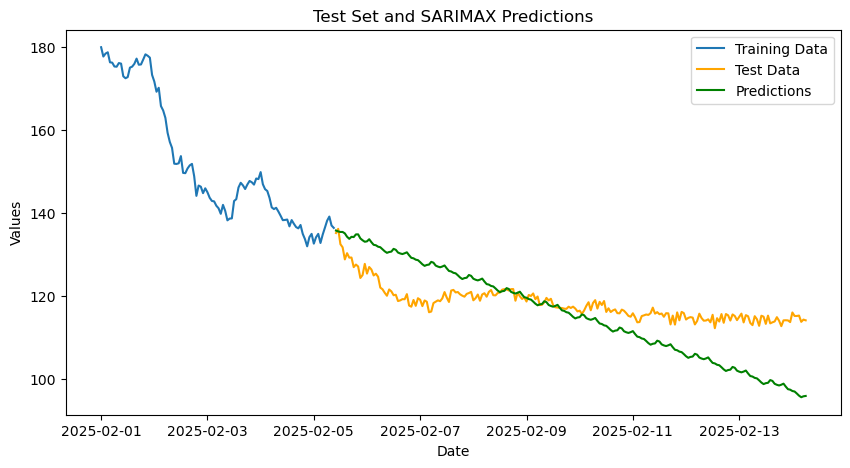

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

train_data, test_data = train_test_split(ask, test_size=0.2, shuffle=False)

sarimax_model2 = SARIMAX(train_data, order=(1, 1, 0), seasonal_order=(1, 1, 1, 17))
sarimax_result2 = sarimax_model2.fit(disp=False)

predictions2 = sarimax_result2.get_forecast(steps=len(test_data)).predicted_mean

mse = mean_squared_error(test_data, predictions2)

print(f'Test MSE: {mse:.2f}')

start_date = '2025-02-01 00:00:00'
plt.figure(figsize=(10, 5))
plt.plot(train_data.loc[start_date:].index, train_data.loc[start_date:], label='Training Data')
plt.plot(test_data.loc[start_date:].index, test_data.loc[start_date:], label='Test Data', color='orange')
plt.plot(test_data.loc[start_date:].index, predictions2.loc[start_date:], label='Predictions', color='green')
plt.title('Test Set and SARIMAX Predictions')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

In [33]:
index = predictions2.index

pred = pd.DataFrame({
    'price': predictions2,
}, index=index)

print(pred.head())



                          price
2025-02-05 10:00:00  135.615172
2025-02-05 11:00:00  135.551537
2025-02-05 12:00:00  135.296503
2025-02-05 13:00:00  135.425311
2025-02-05 14:00:00  135.066030


In [37]:
span = 4
#index for TEMA
pred['EMA1'] = pred['price'].ewm(span=span, adjust=False).mean()
pred['EMA2'] = pred['EMA1'].ewm(span=span, adjust=False).mean()
pred['EMA3'] = pred['EMA2'].ewm(span=span, adjust=False).mean()

#index for P-MA
pred['SMA_50'] = pred['price'].rolling(window=50).mean()  #50h of SMA
print(pred)
pred.to_csv('pred_with_strategy_index.csv', index=False)
# #set trading signals
# pred['Signal'] = 0
# pred['Signal'][pred['price'] > pred['SMA_50']] = 1  
# pred['Signal'][pred['price'] < pred['SMA_50']] = -1 
# pred['Positions'] = pred['Signal'].diff()  # trading strategy e.g. trade when signal changes

                          price        EMA1        EMA2        EMA3  \
2025-02-05 10:00:00  135.615172  135.615172  135.615172  135.615172   
2025-02-05 11:00:00  135.551537  135.589718  135.604991  135.611099   
2025-02-05 12:00:00  135.296503  135.472432  135.551967  135.587447   
2025-02-05 13:00:00  135.425311  135.453584  135.512614  135.557513   
2025-02-05 14:00:00  135.066030  135.298562  135.426993  135.505305   
...                         ...         ...         ...         ...   
2025-02-14 02:00:00   95.838347   96.345133   96.784697   97.182990   
2025-02-14 03:00:00   95.365443   95.953257   96.452121   96.890643   
2025-02-14 04:00:00   95.012624   95.577004   96.102074   96.575215   
2025-02-14 05:00:00   95.239355   95.441944   95.838022   96.280338   
2025-02-14 06:00:00   95.320545   95.393385   95.660167   96.032270   

                         SMA_50  
2025-02-05 10:00:00         NaN  
2025-02-05 11:00:00         NaN  
2025-02-05 12:00:00         NaN  
2025-02-05 